In [1]:
GPU = True

In [2]:
import os
from tqdm import tqdm
from termcolor import colored
import numpy as np

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


### Mnist Dataset

In [4]:
from torch.utils.data import Dataset
import warnings
from PIL import Image
import os
import os.path
import numpy as np
import torch
import codecs
import string
import gzip
import lzma
from torchvision.datasets.utils import download_url, download_and_extract_archive, extract_archive, \
    verify_str_arg

class MNIST(Dataset):
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``MNIST/processed/training.pt``
            and  ``MNIST/processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    resources = [
        ("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", "f68b3c2dcbeaaa9fbdd348bbdeb94873"),
        ("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz", "d53e105ee54ea40749a09fcbcd1e9432"),
        ("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", "9fb629c4189551a2d022fa330f9573f3"),
        ("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz", "ec29112dd5afa0611ce80d1b7f02629c")
    ]

    training_file = 'training.pt'
    test_file = 'test.pt'
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data

    def __init__(self, root="../tmp", train=True,
            transform=None, download=False):
        super(MNIST, self).__init__()
        self.root = root
        self.transform = transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file
        self.data, self.targets = torch.load(os.path.join(self.processed_folder, data_file))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')
        img_size = img.size

        if self.transform is not None:
            img = self.transform(img)

        out = {'image': img, 'target': target, 'meta': {'im_size': img_size, 'index': index}}

        return out

    def get_image(self, index):
        img = self.data[index]
        return img

    def __len__(self):
        return len(self.data)

    @property
    def raw_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'processed')

    @property
    def class_to_idx(self):
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self):
        return (os.path.exists(os.path.join(self.processed_folder,
                                            self.training_file)) and
                os.path.exists(os.path.join(self.processed_folder,
                                            self.test_file)))

    def download(self):
        """Download the MNIST data if it doesn't exist in processed_folder already."""

        if self._check_exists():
            return

        os.makedirs(self.raw_folder, exist_ok=True)
        os.makedirs(self.processed_folder, exist_ok=True)

        # download files
        for url, md5 in self.resources:
            filename = url.rpartition('/')[2]
            download_and_extract_archive(url, download_root=self.raw_folder, filename=filename, md5=md5)

        # process and save as torch files
        print('Processing...')

        training_set = (
            read_image_file(os.path.join(self.raw_folder, 'train-images-idx3-ubyte')),
            read_label_file(os.path.join(self.raw_folder, 'train-labels-idx1-ubyte'))
        )
        test_set = (
            read_image_file(os.path.join(self.raw_folder, 't10k-images-idx3-ubyte')),
            read_label_file(os.path.join(self.raw_folder, 't10k-labels-idx1-ubyte'))
        )
        with open(os.path.join(self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')



### SimCLR

In [5]:
# Configuration
base_folder = "/tmp"
p = {'setup': 'simclr',
 'backbone': 'simple_net',
 'model_kwargs': {'head': 'mlp', 'features_dim': 128},
 'train_db_name': 'mnist',
 'val_db_name': 'mnist',
 'num_classes': 10,
 'criterion': 'simclr',
 'criterion_kwargs': {'temperature': 0.1},
 'epochs': 31,
 'optimizer': 'sgd',
 'optimizer_kwargs': {'nesterov': False,
  'weight_decay': 0.0001,
  'momentum': 0.9,
  'lr': 0.4},
 'scheduler': 'cosine',
 'scheduler_kwargs': {'lr_decay_rate': 0.1},
 'batch_size': 48,
 'num_workers': 8,
 'augmentation_strategy': 'simclr',
 'augmentation_kwargs': 
     {'random_resized_crop': {'size': 32, 'scale': [0.2, 1.0]},
      'color_jitter_random_apply': {'p': 0.8},
      'color_jitter': {'brightness': 0.4, 'contrast': 0.4, 'saturation': 0.4, 'hue': 0.1},
      'random_grayscale': {'p': 0.2},
      'normalize': {'mean': [0.5], 'std': [0.5]}
     },
 'transformation_kwargs': 
     {'crop_size': 32,
      'normalize': {'mean': [0.5], 'std': [0.5]}
     },
 'pretext_dir': f'{base_folder}/mnist/pretext',
 'pretext_checkpoint': f'{base_folder}/mnist/pretext/checkpoint.pth.tar',
 'pretext_model': f'{base_folder}/mnist/pretext/model.pth.tar',
 'topk_neighbors_train_path': f'{base_folder}/mnist/pretext/topk-train-neighbors.npy',
 'topk_neighbors_val_path': f'{base_folder}/mnist/pretext/topk-val-neighbors.npy'}





In [6]:
# Create dst directories
os.makedirs(os.path.dirname(p['pretext_dir']), exist_ok=True)
os.makedirs(os.path.dirname(p['pretext_checkpoint']), exist_ok=True)
os.makedirs(os.path.dirname(p['pretext_model']), exist_ok=True)
os.makedirs(os.path.dirname(p['topk_neighbors_train_path']), exist_ok=True)
os.makedirs(os.path.dirname(p['topk_neighbors_val_path']), exist_ok=True)


#### Model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class ContrastiveModel(nn.Module):
    def __init__(self, backbone, head='mlp', features_dim=128):
        super(ContrastiveModel, self).__init__()
        self.backbone = backbone['backbone']
        self.backbone_dim = backbone['dim']
        self.head = head
 
        if head == 'linear':
            self.contrastive_head = nn.Linear(self.backbone_dim, features_dim)

        elif head == 'mlp':
            self.contrastive_head = nn.Sequential(
                    nn.Linear(self.backbone_dim, self.backbone_dim),
                    nn.ReLU(), nn.Linear(self.backbone_dim, features_dim))
        
        else:
            raise ValueError('Invalid head {}'.format(head))

    def forward(self, x):
        features = self.contrastive_head(self.backbone(x))
        features = F.normalize(features, dim=1)
        return features


In [9]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(12544, 128)
        # self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        # x = self.dropout2(x)
        # x = self.fc2(x)
        # output = F.log_softmax(x, dim=1)
        output = x
        return output

def simple_net(**kwargs):
    return {'backbone': SimpleNet(), 'dim': 128}


#### SimCLR Loss

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
EPS=1e-8


class SimCLRLoss(nn.Module):
    # Based on the implementation of SupContrast
    def __init__(self, temperature):
        super(SimCLRLoss, self).__init__()
        self.temperature = temperature

    
    def forward(self, features):
        """
        input:
            - features: hidden feature representation of shape [b, 2, dim]

        output:
            - loss: loss computed according to SimCLR 
        """

        b, n, dim = features.size()
        assert(n == 2)
        mask = torch.eye(b, dtype=torch.float32).cuda()

        contrast_features = torch.cat(torch.unbind(features, dim=1), dim=0)
        anchor = features[:, 0]

        # Dot product
        dot_product = torch.matmul(anchor, contrast_features.T) / self.temperature
        
        # Log-sum trick for numerical stability
        logits_max, _ = torch.max(dot_product, dim=1, keepdim=True)
        logits = dot_product - logits_max.detach()

        mask = mask.repeat(1, 2)
        logits_mask = torch.scatter(torch.ones_like(mask), 1, torch.arange(b).view(-1, 1).cuda(), 0)
        mask = mask * logits_mask

        # Log-softmax
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
        
        # Mean log-likelihood for positive
        loss = - ((mask * log_prob).sum(1) / mask.sum(1)).mean()

        return loss


In [11]:
features = torch.tensor(np.zeros((8,2,100)))
features.size()
b, n, dim = features.size()
assert(n == 2)
mask = torch.eye(b, dtype=torch.float32).cuda()

contrast_features = torch.cat(torch.unbind(features, dim=1), dim=0)
anchor = features[:, 0]


In [12]:
contrast_features.T.size()

torch.Size([100, 16])

In [13]:
x=torch.matmul(anchor, contrast_features.T) / 1
x.size()

torch.Size([8, 16])

#### Init model

In [14]:
backbone = simple_net()
model = ContrastiveModel(backbone, **p['model_kwargs'])
if GPU:
    model = model.cuda()

print('Model parameters: {:.2f}M'.format(sum(p.numel() for p in model.parameters()) / 1e6))
# print(model)


Model parameters: 1.66M


### Augmentations

In [15]:
import torchvision.transforms as transforms

In [16]:
train_transforms =  transforms.Compose([
                transforms.Resize(48),
                transforms.RandomResizedCrop(**p['augmentation_kwargs']['random_resized_crop']),
                transforms.RandomHorizontalFlip(),
                transforms.RandomApply(
                    [transforms.ColorJitter(**p['augmentation_kwargs']['color_jitter'])],
                    p=p['augmentation_kwargs']['color_jitter_random_apply']['p']
                ),
                transforms.RandomGrayscale(**p['augmentation_kwargs']['random_grayscale']),
                transforms.ToTensor(),
                transforms.Normalize(**p['augmentation_kwargs']['normalize'])
            ])
print('Train transforms:', train_transforms)


Train transforms: Compose(
    Resize(size=48, interpolation=PIL.Image.BILINEAR)
    RandomResizedCrop(size=(32, 32), scale=(0.2, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    RandomApply(
    p=0.8
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[-0.1, 0.1])
)
    RandomGrayscale(p=0.2)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)


In [17]:
val_transforms = transforms.Compose([
            transforms.Resize(48),
            transforms.CenterCrop(p['transformation_kwargs']['crop_size']),
            transforms.ToTensor(),
            transforms.Normalize(**p['transformation_kwargs']['normalize'])])
print('Val transforms:', val_transforms)


Val transforms: Compose(
    Resize(size=48, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(32, 32))
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)


### Load datasets

In [18]:
from torch.utils.data import Dataset

#### Original dataset

In [19]:
train_dataset = MNIST(root=f"{base_folder}", train=True, transform=train_transforms, download=True)
val_dataset   = MNIST(root=f"{base_folder}", train=False, transform=val_transforms, download=True)

#### Augmentated datase

In [20]:
import numpy as np
import torch
from torch.utils.data import Dataset

class AugmentedDataset(Dataset):
    def __init__(self, dataset):
        super(AugmentedDataset, self).__init__()
        transform = dataset.transform
        dataset.transform = None
        self.dataset = dataset
        
        self.image_transform = transform
        self.augmentation_transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        sample = self.dataset.__getitem__(index)
        image = sample['image']
        
        sample['image'] = self.image_transform(image)
        sample['image_augmented'] = self.augmentation_transform(image)

        return sample


In [21]:
# Dataset returns an image and an augmentation of that image.
train_dataset = AugmentedDataset(train_dataset)


In [22]:
# Example of new dataset items:
train_dataset.__getitem__(4)

{'image': tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9216, -1.0000, -1.0000]]]),
 'target': 9,
 'meta': {'im_size': (28, 28), 'index': 4},
 'image_augmented': tensor([[[-0.9059, -0.9059, -0.9059,  ..., -0.9059, -0.9059, -0.9059],
          [-0.9059, -0.9059, -0.9059,  ..., -0.9059, -0.9059, -0.9059],
          [-0.9059, -0.9059, -0.9059,  ..., -0.9059, -0.9059, -0.9059],
          ...,
          [-0.9059, -0.9059, -0.9059,  ..., -0.9059, -0.9059, -0.9059],
          [-0.9059, -0.9059, -0.9059,  ..., -0.9059, -0.9059, -0.9059],
          [-0.9059, -0.9059, -0.9059,  ..., -0.9059, -0.9059, -0.9059]]])}

#### Dataloaders

In [23]:
print(p['num_workers']) # 8
print(p['batch_size']) # 48
import collections
from torch._six import string_classes, int_classes

# Not sure why?
def collate_custom(batch):
    if isinstance(batch[0], np.int64):
        return np.stack(batch, 0)

    if isinstance(batch[0], torch.Tensor):
        return torch.stack(batch, 0)

    elif isinstance(batch[0], np.ndarray):
        return np.stack(batch, 0)

    elif isinstance(batch[0], int_classes):
        return torch.LongTensor(batch)

    elif isinstance(batch[0], float):
        return torch.FloatTensor(batch)

    elif isinstance(batch[0], string_classes):
        return batch

    elif isinstance(batch[0], collections.Mapping):
        batch_modified = {key: collate_custom([d[key] for d in batch]) for key in batch[0] if key.find('idx') < 0}
        return batch_modified

    elif isinstance(batch[0], collections.Sequence):
        transposed = zip(*batch)
        return [collate_custom(samples) for samples in transposed]

    raise TypeError(('Type is {}'.format(type(batch[0]))))



train_dataloader = torch.utils.data.DataLoader(train_dataset, num_workers=p['num_workers'],
                                       batch_size=p['batch_size'], pin_memory=True, collate_fn=collate_custom,
                                       drop_last=True, shuffle=True)


val_dataloader = torch.utils.data.DataLoader(val_dataset, num_workers=p['num_workers'],
                                       batch_size=p['batch_size'], pin_memory=True, collate_fn=collate_custom,
                                       drop_last=False, shuffle=False)


8
48


#### criterion


In [24]:
print(p['criterion_kwargs']) # {'temperature': 0.1}
criterion = SimCLRLoss(**p['criterion_kwargs'])
criterion = criterion.cuda()


{'temperature': 0.1}


#### Optimizer

In [25]:
def get_optimizer(p, model, cluster_head_only=False):
    # Not sure why?
    if cluster_head_only:  # Only weights in the cluster head will be updated
        for name, param in model.named_parameters():
            if 'cluster_head' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        params = list(filter(lambda p: p.requires_grad, model.parameters()))
        assert (len(params) == 2 * p['num_heads'])

    else:
        params = model.parameters()

    if p['optimizer'] == 'sgd':
        optimizer = torch.optim.SGD(params, **p['optimizer_kwargs'])

    elif p['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(params, **p['optimizer_kwargs'])

    else:
        raise ValueError('Invalid optimizer {}'.format(p['optimizer']))

    return optimizer


print(p['optimizer']) # sgd
print(p['optimizer_kwargs']) # {'nesterov': False, 'weight_decay': 0.0001, 'momentum': 0.9, 'lr': 0.4}
optimizer = get_optimizer(p, model)


sgd
{'nesterov': False, 'weight_decay': 0.0001, 'momentum': 0.9, 'lr': 0.4}


#### Checkpoint

In [26]:
# Checkpoint
if os.path.exists(p['pretext_checkpoint']):
    print(colored('Restart from checkpoint {}'.format(p['pretext_checkpoint']), 'blue'))
    checkpoint = torch.load(p['pretext_checkpoint'], map_location='cpu')
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.load_state_dict(checkpoint['model'])
    model.cuda()
    start_epoch = checkpoint['epoch']

else:
    print(colored('No checkpoint file at {}'.format(p['pretext_checkpoint']), 'blue'))
    start_epoch = 0
    model = model.cuda()
    model = model


Restart from checkpoint /tmp/mnist/pretext/checkpoint.pth.tar


### Training

#### Learning rate strategy

In [27]:
def adjust_learning_rate(p, optimizer, epoch):
    import math
    lr = p['optimizer_kwargs']['lr']

    if p['scheduler'] == 'cosine':
        eta_min = lr * (p['scheduler_kwargs']['lr_decay_rate'] ** 3)
        lr = eta_min + (lr - eta_min) * (1 + math.cos(math.pi * epoch / p['epochs'])) / 2

    elif p['scheduler'] == 'step':
        steps = np.sum(epoch > np.array(p['scheduler_kwargs']['lr_decay_epochs']))
        if steps > 0:
            lr = lr * (p['scheduler_kwargs']['lr_decay_rate'] ** steps)

    elif p['scheduler'] == 'constant':
        lr = lr

    else:
        raise ValueError('Invalid learning rate schedule {}'.format(p['scheduler']))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return lr


#### AverageMeter + ProgressMeter

In [28]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


In [29]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'



#### Training function

In [30]:
def simclr_train(train_loader, model, criterion, optimizer, epoch):
    """ 
    Train according to the scheme from SimCLR
    https://arxiv.org/abs/2002.05709
    """
    losses = AverageMeter('Loss', ':.4e')
    progress = ProgressMeter(len(train_loader),
        [losses],
        prefix="Epoch: [{}]".format(epoch))

    model.train()

    for i, batch in enumerate(train_loader):
        images = batch['image']
        images_augmented = batch['image_augmented']
        b, c, h, w = images.size()
        input_ = torch.cat([images.unsqueeze(1), images_augmented.unsqueeze(1)], dim=1)
        input_ = input_.view(-1, c, h, w) 
        input_ = input_.cuda(non_blocking=True)
        targets = batch['target'].cuda(non_blocking=True)

        output = model(input_).view(b, 2, -1)
        loss = criterion(output)
        losses.update(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 25 == 0:
            progress.display(i)


#### Start Training process

In [31]:
print(colored('Starting main loop', 'blue'))
for epoch in range(start_epoch, p['epochs']):
    print(colored('Epoch %d/%d' %(epoch, p['epochs']), 'yellow'))
    print(colored('-'*15, 'yellow'))

    # Adjust lr
    lr = adjust_learning_rate(p, optimizer, epoch)
    print('Adjusted learning rate to {:.5f}'.format(lr))

    # Train
    print('Train ...')
    simclr_train(train_dataloader, model, criterion, optimizer, epoch)
    
    # Checkpoint
    print('Checkpoint ...')
    torch.save({'optimizer': optimizer.state_dict(), 'model': model.state_dict(), 
                'epoch': epoch + 1}, p['pretext_checkpoint'])

# Save final model
torch.save(model.state_dict(), p['pretext_model'])




Starting main loop
Epoch 30/31
---------------
Adjusted learning rate to 0.00143
Train ...
Epoch: [30][   0/1250]	Loss 6.8048e-01 (6.8048e-01)
Epoch: [30][  25/1250]	Loss 1.1228e+00 (9.2852e-01)
Epoch: [30][  50/1250]	Loss 9.6303e-01 (9.5132e-01)
Epoch: [30][  75/1250]	Loss 9.5643e-01 (9.5905e-01)
Epoch: [30][ 100/1250]	Loss 1.1131e+00 (9.6982e-01)
Epoch: [30][ 125/1250]	Loss 9.2225e-01 (9.6814e-01)
Epoch: [30][ 150/1250]	Loss 7.0908e-01 (9.6426e-01)
Epoch: [30][ 175/1250]	Loss 1.1326e+00 (9.7057e-01)
Epoch: [30][ 200/1250]	Loss 8.5974e-01 (9.7781e-01)
Epoch: [30][ 225/1250]	Loss 9.8173e-01 (9.7445e-01)
Epoch: [30][ 250/1250]	Loss 8.7931e-01 (9.7704e-01)
Epoch: [30][ 275/1250]	Loss 9.7838e-01 (9.7296e-01)
Epoch: [30][ 300/1250]	Loss 1.1185e+00 (9.7570e-01)
Epoch: [30][ 325/1250]	Loss 1.1259e+00 (9.7402e-01)
Epoch: [30][ 350/1250]	Loss 1.2028e+00 (9.7806e-01)
Epoch: [30][ 375/1250]	Loss 9.1693e-01 (9.7710e-01)
Epoch: [30][ 400/1250]	Loss 8.5309e-01 (9.7704e-01)
Epoch: [30][ 425/1250]	Lo

#### Save the validation raw_data, low_dim, labels into npy files

In [32]:
labels = []
raw_data = []
low_dim_data = []
for i, batch in enumerate(val_dataloader):
        images = batch['image']
        b, c, h, w = images.size()
        
        input_ = images
        input_ = input_.cuda(non_blocking=True)
        targets = batch['target'].cuda(non_blocking=True)
        output_backbone = model.backbone(input_)
        
        labels.append(targets.cpu().detach().numpy())
        raw_data.append(images.cpu().detach().numpy())
        low_dim_data.append(output_backbone.cpu().detach().numpy())

        if i == 0:
            print(input_.shape, type(input_))
            print(output_backbone.shape, type(output_backbone))
        
            print(labels[0].shape)
            print(raw_data[0].shape)
            print(low_dim_data[0].shape)
    
labels = np.concatenate(labels, axis=0)
raw_data = np.concatenate(raw_data, axis=0)
low_dim_data = np.concatenate(low_dim_data, axis=0)

np.save(f"{base_folder}/eval_mnist_y.npy", labels)
np.save(f"{base_folder}/eval_mnist_X.npy", raw_data)
np.save(f"{base_folder}/eval_mnist_low_dim_X.npy", low_dim_data)

print(labels.shape)
print(raw_data.shape)
print(low_dim_data.shape)

model

torch.Size([48, 1, 32, 32]) <class 'torch.Tensor'>
torch.Size([48, 128]) <class 'torch.Tensor'>
(48,)
(48, 1, 32, 32)
(48, 128)
(10000,)
(10000, 1, 32, 32)
(10000, 128)


ContrastiveModel(
  (backbone): SimpleNet(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (dropout1): Dropout(p=0.25, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
    (fc1): Linear(in_features=12544, out_features=128, bias=True)
  )
  (contrastive_head): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
)

In [33]:
print(labels.shape)
print(raw_data.shape)
print(raw_data.reshape(raw_data.shape[0]*raw_data.shape[1],-1).shape)
print(low_dim_data.shape)

(10000,)
(10000, 1, 32, 32)
(10000, 1024)
(10000, 128)


#### Umap both raw-data and low-dim representation

In [75]:
import matplotlib.patheffects as PathEffects
def plot_embedding_2d(emebd, colors, title):
    classes_size = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", classes_size))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(emebd[:, 0], emebd[:, 1], lw=0, s=4,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    plt.setp(ax, xticks=[], yticks=[])
    plt.title(title, fontsize=18)

    ax.axis('tight')

    # Add the label caption
    txts = []
    for i in range(classes_size):

        # Position of each label.
        xtext, ytext = np.median(emebd[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.show()
    return f, ax, sc, txts

run cell 2021-07-10 17:29:26
(10000,)
(10000, 1, 32, 32)
(10000, 128)
(10000, 1024)
Start umap low_dim_data 2021-07-10 17:29:26
low_dim_data.shape (10000, 128)
End umap low_dim_data 2021-07-10 17:29:52
Start umap raw_data_1d 2021-07-10 17:29:52
raw_data_1d.shape (10000, 1024)
End umap raw_data_1d 2021-07-10 17:30:14
END


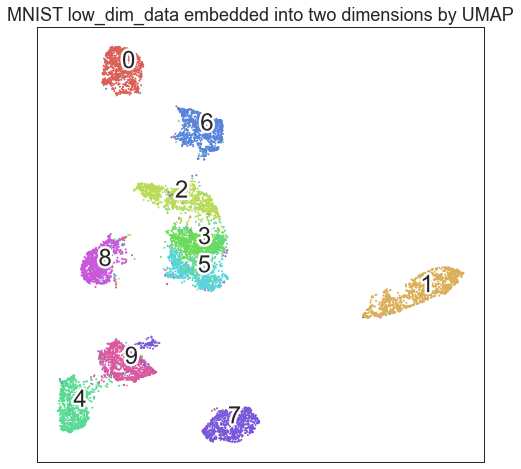

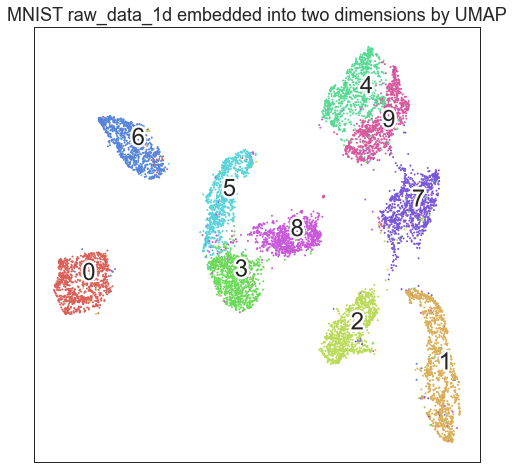

In [76]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
print("run cell", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

sns.set(context="paper", style="white")


raw_data = np.load(f"{base_folder}/eval_mnist_X.npy")
low_dim_data = np.load(f"{base_folder}/eval_mnist_low_dim_X.npy")
labels = np.load(f"{base_folder}/eval_mnist_y.npy")
raw_data_1d = raw_data.reshape(raw_data.shape[0], -1)

print(labels.shape)
print(raw_data.shape)
print(low_dim_data.shape)
print(raw_data_1d.shape)


################## umap low_dim_data ##################

print("Start umap low_dim_data", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print("low_dim_data.shape", low_dim_data.shape)
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(low_dim_data)
print("End umap low_dim_data", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

plot_embedding_2d(embedding, labels.astype(int), "MNIST low_dim_data embedded into two dimensions by UMAP")


################## umap raw_data_1d ##################
print("-"*30)
print("Start umap raw_data_1d", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print("raw_data_1d.shape", raw_data_1d.shape)
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(raw_data_1d)
print("End umap raw_data_1d", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

plot_embedding_2d(embedding, labels.astype(int), "MNIST raw_data_1d embedded into two dimensions by UMAP")

print("END")
# fig, ax = plt.subplots(figsize=(12, 10))
# color =  labels.astype(int)
# plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=5)
# plt.setp(ax, xticks=[], yticks=[])
# plt.title("MNIST raw_data_1d embedded into two dimensions by UMAP", fontsize=18)
# cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
# cbar.set_ticks(np.arange(10))
# plt.show()
